In [1]:
import pandas as pd 
import requests 
import json 
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.dates as mdates 
import matplotlib.ticker as mticker
from matplotlib.finance import candlestick_ohlc
from matplotlib import style
style.use("ggplot")
from matplotlib.dates import date2num
import datetime

# make a GET request to the API of crytpocomare  and store the response in a variable called response
response = requests.get("https://min-api.cryptocompare.com/data/histohour?fsym=BTC&tsym=USD&e=BTCE&limit=2000&aggregate=1&timestamp='2017-04-01'")
bitcoin_dict = response.json()
columns = ["close","high","low","open","time","volumefrom","volumeto"]

In [2]:
# Generate a dataframe named bitcoin_data with ohlcv data in 1 hour 
bitcoin_data = pd.DataFrame(bitcoin_dict["Data"],columns=columns)
bitcoin_data.dtypes

close         float64
high          float64
low           float64
open          float64
time            int64
volumefrom    float64
volumeto      float64
dtype: object

In [3]:
# Create the column Date that convert the time column in a timestamp object 
bitcoin_data["Date"] = pd.to_datetime(bitcoin_data["time"], unit="s")
bitcoin_data = bitcoin_data.drop("time",axis=1)



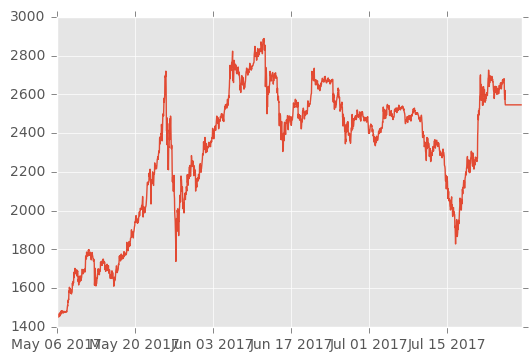

In [4]:
# Get a glance of the bitcoin series 
plt.plot(bitcoin_data["Date"],bitcoin_data["close"])
plt.show()

In [5]:
bitcoin_data.head()

,close,high,low,open,volumefrom,volumeto,Date
0,1443.00,1445.40,1433.98,1433.98,91.78,132147.08,2017-05-06 00:00:00
1,1453.20,1454.07,1437.11,1443.00,144.44,208839.37,2017-05-06 01:00:00
2,1446.32,1457.00,1445.40,1453.20,180.41,262186.53,2017-05-06 02:00:00
3,1450.10,1455.00,1445.50,1446.32,63.11,91504.70,2017-05-06 03:00:00
4,1460.15,1460.22,1450.01,1450.10,290.63,423495.61,2017-05-06 04:00:00


In [6]:
# Organize the bitcoin_data dataframe 
bitcoin_data = bitcoin_data[["Date","open","high","low","close","volumefrom","volumeto"]]

In [7]:
# Calculate the Exponential Moving Average with window=12
ema_12 = bitcoin_data["close"].ewm(span=12).mean()
bitcoin_data["ema_12"] = ema_12

In [8]:
# Calculate the Exponential Moving Average with window=26
ema_26 = bitcoin_data["close"].ewm(span=26).mean()
bitcoin_data["ema_26"] = ema_26 

In [9]:
# Calculate the macd indicator 
macd_ti = bitcoin_data["close"].ewm(span=12).mean() - bitcoin_data["close"].ewm(span=26).mean()
macd_ti
bitcoin_data["macd_ti"] = macd_ti




In [10]:
# Calculate the macd signal 
bitcoin_data["signal_macd"] = bitcoin_data["macd_ti"].ewm(span=9).mean()

In [11]:
# Calculate the macd_histogram 
bitcoin_data["macd_histogram"] = bitcoin_data["macd_ti"] - bitcoin_data["signal_macd"]

In [12]:
# Generate some volatility indicators 
bitcoin_data["H-L"] = bitcoin_data["high"] - bitcoin_data["low"]
bitcoin_data["H-YC"] = abs(bitcoin_data["high"] - bitcoin_data["close"].shift(1))
bitcoin_data["L-YC"] = abs(bitcoin_data["low"] - bitcoin_data["close"].shift(1))

In [13]:
def TR(row): # date,close,high,low,open,yesterday close
    TR=0
    if row["H-YC"] <= row["H-L"] >= row["L-YC"]:
        TR = row["H-L"]
    elif  row["H-L"]<= row["H-YC"] >=row["L-YC"]:
        TR = row["H-YC"]
    elif row["H-L"] <= row["L-YC"] >= row["H-YC"]:
        TR = row["H-YC"]
      
    return TR

bitcoin_data["TR"] = bitcoin_data.apply(TR,axis=1)

In [14]:
# Calculate the Average True Range Indicator 
bitcoin_data["ATR"] = bitcoin_data["TR"].ewm(span=14).mean()

In [15]:
# Calculate the ADX indicator to asses the strenght of the trend and filter trades that are are less than a fixed number of the ADX
bitcoin_data["moveUp"] = bitcoin_data["high"] - bitcoin_data["high"].shift(1) 
bitcoin_data["moveDown"] = bitcoin_data["low"].shift(1) - bitcoin_data["low"]

bitcoin_data["PDM"] = np.where(bitcoin_data["moveUp"] > bitcoin_data["moveDown"], bitcoin_data["moveUp"],0)
bitcoin_data["NDM"] = np.where(bitcoin_data["moveDown"] > bitcoin_data["moveUp"],bitcoin_data["moveDown"],0)
bitcoin_data["expPosDM"] = bitcoin_data["PDM"].ewm(span=14).mean()
bitcoin_data["expNegDM"] = bitcoin_data["NDM"].ewm(span=14).mean()
bitcoin_data["PDI"] = 100*(bitcoin_data["expPosDM"] / bitcoin_data["ATR"]) 
bitcoin_data["NDI"] = 100*(bitcoin_data["expNegDM"] / bitcoin_data["ATR"])
bitcoin_data["DX"] = 100*((abs(bitcoin_data["PDI"] - bitcoin_data["NDI"])) / (bitcoin_data["PDI"] + bitcoin_data["NDI"]))

In [16]:
bitcoin_data["ADX"] = bitcoin_data["DX"].ewm(span=14).mean()

In [17]:

bitcoin_data["20d"] = np.round(bitcoin_data["close"].rolling(window = 20, center = False).mean(), 2)
bitcoin_data["50d"] = np.round(bitcoin_data["close"].rolling(window = 50, center = False).mean(), 2)
bitcoin_data.head()

,Date,open,high,low,close,volumefrom,volumeto,ema_12,ema_26,macd_ti,...,PDM,NDM,expPosDM,expNegDM,PDI,NDI,DX,ADX,20d,50d
0,2017-05-06 00:00:00,1433.98,1445.40,1433.98,1443.00,91.78,132147.08,1443.000000,1443.000000,0.000000,...,0.00,0.0,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-05-06 01:00:00,1443.00,1454.07,1437.11,1453.20,144.44,208839.37,1448.525000,1448.296154,0.228846,...,8.67,0.0,4.644643,0.000000,51.120283,0.000000,100.000000,100.000000,NaN,NaN
2,2017-05-06 02:00:00,1453.20,1457.00,1445.40,1446.32,180.41,262186.53,1447.664388,1447.586141,0.078247,...,2.93,0.0,3.989643,0.000000,39.713040,0.000000,100.000000,100.000000,NaN,NaN
3,2017-05-06 03:00:00,1446.32,1455.00,1445.50,1450.10,63.11,91504.70,1448.433216,1448.288906,0.144309,...,0.00,-0.1,2.769099,-0.030593,28.029905,-0.309673,102.234271,100.853499,NaN,NaN
4,2017-05-06 04:00:00,1450.10,1460.22,1450.01,1460.15,290.63,423495.61,1451.616624,1451.039543,0.577081,...,5.22,0.0,3.408535,-0.022611,34.203621,-0.226897,101.335600,101.000987,NaN,NaN


In [18]:
# The backTesting function, has the functionality of simulate and backtest the strategy with the MACD indicator. 
# The goal of the function is trigger the trades when the condictions are met and show information of each trade such as
# the entry price, exit price, datetime information, profit of each trade and total profit. 
def backTesting():
    x = 0

    lastBoughtFor = 0
    stance = "none"
    totalProfit = 0
     #datetime.datetime.fromtimestamp(float(bitcoin_OHLCV.index)).strftime("%Y-%m-%d")))
    while x < len(bitcoin_data):
        if stance == "none":
            if  (bitcoin_data["macd_ti"][x] <0) & (bitcoin_data["signal_macd"][x]<0) & (bitcoin_data["macd_ti"][x] > bitcoin_data["signal_macd"][x]) & (bitcoin_data["ADX"][x] > 20): #& (bitcoin_data["close"][x] >bitcoin_data["20d"][x]): # oversold, let´s buy
                print("starting time", str(bitcoin_data["Date"][x]))
                stance = "holding"
                print("Buying BTC @", bitcoin_data["close"][x])
                print("macd:", bitcoin_data["macd_ti"][x], "macd_signal:",bitcoin_data["signal_macd"][x])
                lastBoughtFor = bitcoin_data["close"][x]
                
        elif stance == "holding":
            if (bitcoin_data["macd_ti"][x] < bitcoin_data["signal_macd"][x]):
                stance = "none"
                print("Selling BTC @", bitcoin_data["close"][x])
                fees = (.002)*(bitcoin_data["close"][x] + lastBoughtFor)
                print("finish time",bitcoin_data["Date"][x])
                print("macd:", bitcoin_data["macd_ti"][x], "macd_signal:",bitcoin_data["signal_macd"][x])
                print("Fee for this was",fees)
                print("Profit on this trade:",bitcoin_data["close"][x] - lastBoughtFor - fees) # if we lost money this is negative 
                totalProfit += (bitcoin_data["close"][x] - lastBoughtFor - fees)
        
            
        
        x +=1
    print("total profit of", totalProfit)
backTesting()

starting time 2017-05-13 08:00:00
Buying BTC @ 1667.0
macd: -26.6312255663 macd_signal: -28.618455081
Selling BTC @ 1726.5
finish time 2017-05-14 13:00:00
macd: 10.8143756633 macd_signal: 11.3384052076
Fee for this was 6.787
Profit on this trade: 52.713
starting time 2017-05-15 22:00:00
Buying BTC @ 1689.41
macd: -11.1526864575 macd_signal: -12.1639880283
Selling BTC @ 1647.41
finish time 2017-05-16 04:00:00
macd: -10.6163370879 macd_signal: -10.5715194365
Fee for this was 6.67364
Profit on this trade: -48.67364
starting time 2017-05-16 10:00:00
Buying BTC @ 1651.0
macd: -12.5894624318 macd_signal: -12.6138613361
Selling BTC @ 1750.0
finish time 2017-05-17 17:00:00
macd: 20.1764016648 macd_signal: 20.865032456
Fee for this was 6.802
Profit on this trade: 92.198
starting time 2017-05-26 07:00:00
Buying BTC @ 2407.6
macd: -32.0362981056 macd_signal: -34.1235048655
Selling BTC @ 2320.0
finish time 2017-05-26 14:00:00
macd: -17.1394299469 macd_signal: -16.0237510287
Fee for this was 9.4552

In [19]:
# In the following cells, I would code the entry and exit signals in vecotired code and afterwards, generate some metrics 
# of the strategy in order to view the results. First I start generating the entry_signals and exit_signals of the strategy 

bitcoin_data["entry_signals"] = np.where((bitcoin_data["macd_ti"] < 0) & (bitcoin_data["signal_macd"] < 0) & (bitcoin_data["macd_histogram"].shift(1) < 0) & (bitcoin_data["macd_histogram"] >0) & (bitcoin_data["ADX"] > 20),1,0)

bitcoin_data["exit_signals"] = np.where(bitcoin_data["macd_ti"] < bitcoin_data["signal_macd"],1,0)
print(len(bitcoin_data[bitcoin_data["entry_signals"] ==1]))
print(len(bitcoin_data[bitcoin_data["exit_signals"]==1]))

32
934


In [20]:
# I filter the exit_signals with the generation of a variable called filtered_exit. With this variable it is garantized that
# that the exit of trade take place when an operation is open. The variable filtered_exit take the value of 1 only if there is a trade in place. 
bitcoin_data["filtered_exit"] = np.nan


In [21]:
for i, data in bitcoin_data.iterrows():
    holding_status = (bitcoin_data.loc[:(i-1), 'entry_signals'] - bitcoin_data.loc[:(i-1), 'filtered_exit']).sum()
    
    if bitcoin_data["exit_signals"][i] == 0 or i == 0:
        bitcoin_data.loc[i, 'filtered_exit'] = 0
    elif bitcoin_data["exit_signals"][i] == 1:
        if holding_status == 0:
            bitcoin_data.loc[i, 'filtered_exit'] = 0
        elif holding_status == 1:
            bitcoin_data.loc[i, 'filtered_exit'] = 1

In [22]:
bitcoin_data[["Date", "macd_ti","signal_macd","entry_signals","exit_signals","filtered_exit"]].tail()


,Date,macd_ti,signal_macd,entry_signals,exit_signals,filtered_exit
1996,2017-07-28 04:00:00,-0.530698,-0.777970,0,0,0.0
1997,2017-07-28 05:00:00,-0.491479,-0.720672,0,0,0.0
1998,2017-07-28 06:00:00,-0.455150,-0.667568,0,0,0.0
1999,2017-07-28 07:00:00,-0.421501,-0.618354,0,0,0.0
2000,2017-07-28 08:00:00,-0.390334,-0.572750,0,0,0.0


In [23]:
# Create the trades data frame with some information of the trades that were triggered with the strategy 
trades = pd.concat([pd.DataFrame({"Date": bitcoin_data.loc[bitcoin_data["entry_signals"]==1,"Date"], "Price": bitcoin_data.loc[bitcoin_data["entry_signals"]==1,"close"],
                                   "Regime":bitcoin_data.loc[bitcoin_data["entry_signals"]==1,"entry_signals"],
                                   "Signal": "Buy"}),
                    pd.DataFrame({"Date": bitcoin_data.loc[bitcoin_data["filtered_exit"]==1,"Date"], "Price":bitcoin_data.loc[bitcoin_data["filtered_exit"]==1,"close"],
                                 "Regime":bitcoin_data.loc[bitcoin_data["filtered_exit"]==1,"filtered_exit"],
                                 "Signal":"Sell"}),])
trades.sort_index(inplace=True)
trades.shape

(63, 4)

In [24]:
trades.index = pd.to_datetime(trades["Date"],unit="s")
trades = trades.drop("Date",axis=1)
trades = trades[:62]

In [25]:
# Create the trades_long_profits that show the datetime at the entry moment(index), the end time of the trade, the price at which
# the trades was trigered and the profit of the trade
trades_long_profits = pd.DataFrame({
        
    "End_date":  trades["Price"].loc[trades.loc[trades["Signal"].shift(1)=="Buy"].index].index,
    "Price":trades.loc[(trades["Signal"]=="Buy") & trades["Regime"]==1,"Price"],
    "Profit":pd.Series(trades["Price"] - trades["Price"].shift(1) - (0.002*(trades["Price"] + trades["Price"].shift(1)))).loc[trades.loc[(trades["Signal"].shift(1)=="Buy")
        &(trades["Regime"].shift(1)==1)].index].tolist(),
                       })
trades_long_profits

,End_date,Price,Profit
Date,,,
2017-05-13 08:00:00,2017-05-14 13:00:00,1667.00,52.71300
2017-05-15 22:00:00,2017-05-16 04:00:00,1689.41,-48.67364
2017-05-16 10:00:00,2017-05-17 17:00:00,1651.00,92.19800
2017-05-26 07:00:00,2017-05-26 14:00:00,2407.60,-97.05520
2017-05-27 13:00:00,2017-05-28 15:00:00,1892.00,110.19600
2017-05-31 10:00:00,2017-06-01 17:00:00,2185.82,104.03072
2017-06-08 05:00:00,2017-06-08 13:00:00,2696.90,-74.45002
2017-06-08 19:00:00,2017-06-09 20:00:00,2659.07,61.14986
2017-06-13 01:00:00,2017-06-14 11:00:00,2610.00,65.41798


In [26]:
investment = 100000
trades_long_profits["portfolio_value"] =  investment  + trades_long_profits["Profit"].cumsum()
trades_long_profits["returns"] = ((trades_long_profits["portfolio_value"] / trades_long_profits["portfolio_value"].shift(1)) -1) * 100


In [27]:
import math
def create_drawdown(pnl):
    hwm =[0]
    idx = pnl.index
    drawdown = pd.Series(index = idx)
    duration = pd.Series(index = idx)
    for t in range(1, len(idx)):
        hwm.append(max(hwm[t-1], pnl[t]))
        drawdown[t] = (hwm[t] -pnl[t]) 
        duration[t] = (0 if drawdown[t] == 0 else duration[t-1] +1)
    return drawdown, drawdown.max() , duration.max() 

trades_long_profits["drawdown"] = create_drawdown(trades_long_profits["returns"])[0]
trades_long_profits["net_profit"] = trades_long_profits["portfolio_value"] - 100000
#trades_long_profits["trade_size"] = (1+ math.sqrt(1 + 8 * (trades_long_profits["net_profit"].values/ 93)))
trades_long_profits

,End_date,Price,Profit,portfolio_value,returns,drawdown,net_profit
Date,,,,,,,
2017-05-13 08:00:00,2017-05-14 13:00:00,1667.00,52.71300,100052.71300,NaN,NaN,52.71300
2017-05-15 22:00:00,2017-05-16 04:00:00,1689.41,-48.67364,100004.03936,-0.048648,0.048648,4.03936
2017-05-16 10:00:00,2017-05-17 17:00:00,1651.00,92.19800,100096.23736,0.092194,0.000000,96.23736
2017-05-26 07:00:00,2017-05-26 14:00:00,2407.60,-97.05520,99999.18216,-0.096962,0.189156,-0.81784
2017-05-27 13:00:00,2017-05-28 15:00:00,1892.00,110.19600,100109.37816,0.110197,0.000000,109.37816
2017-05-31 10:00:00,2017-06-01 17:00:00,2185.82,104.03072,100213.40888,0.103917,0.006280,213.40888
2017-06-08 05:00:00,2017-06-08 13:00:00,2696.90,-74.45002,100138.95886,-0.074291,0.184488,138.95886
2017-06-08 19:00:00,2017-06-09 20:00:00,2659.07,61.14986,100200.10872,0.061065,0.049132,200.10872
2017-06-13 01:00:00,2017-06-14 11:00:00,2610.00,65.41798,100265.52670,0.065287,0.044910,265.52670


In [28]:
import math
def trade_size(row):
    for i, row in trades_long_profits.iterrows():
        trade_size = 0.5 + math.sqrt(1 + 8 *(row["net_profit"] / 93))
    return trade_size

bitcoin_data["trade_size"] = bitcoin_data.apply(trade_size,axis=1)

In [29]:
Total_Gross_Win = trades_long_profits[trades_long_profits["Profit"] > 0].sum()["Profit"]
Total_Gross_Loss = trades_long_profits[trades_long_profits["Profit"] < 0].sum()["Profit"]
Profit_Factor = abs(Total_Gross_Win / Total_Gross_Loss)
Total_Net_Profit = (Total_Gross_Win + Total_Gross_Loss)
Number_Winning_Trades = trades_long_profits[trades_long_profits["Profit"] > 0].count()["Profit"]
Number_Lossing_Trades = trades_long_profits[trades_long_profits["Profit"] < 0].count()["Profit"]
Percentage_Profitable_Trades = (Number_Winning_Trades) / (Number_Winning_Trades + Number_Lossing_Trades)
Largest_Profitable_Trade = max(trades_long_profits["Profit"])
Largest_Losing_Trade = min(trades_long_profits["Profit"])
Max_Draw_Down = trades_long_profits["drawdown"].max()

In [30]:
def sharpe_ratio(returns):
    return (returns.mean() / returns.std()) * np.sqrt(len(trades_long_profits))
Sharpe_ratio = sharpe_ratio(trades_long_profits["returns"])

In [31]:
print("Total_Gross_Win:", Total_Gross_Win )
print("Total_Gross_Loss:", Total_Gross_Loss)
print("Profit_Factor:", Profit_Factor)
print("Total_Net_Profit", Total_Net_Profit)
print("Number_Winning_Trades:", Number_Winning_Trades)
print("Average_Winning_Trade:",Total_Gross_Win / Number_Winning_Trades)
print("Number_Lossing_Trades:", Number_Lossing_Trades)
print("Average_Lossing_Trade:", Total_Gross_Loss / Number_Lossing_Trades)
print("Percentage_Profitable_Trades:", Percentage_Profitable_Trades)
print("Largest_Profitable_Trade:", Largest_Profitable_Trade)
print("Largest_Losing_Trade:", Largest_Losing_Trade)
print("Max_Draw_Down:", Max_Draw_Down)
print("Sharpe_ratio:",Sharpe_ratio)

Total_Gross_Win: 1196.42912
Total_Gross_Loss: -974.70086
Profit_Factor: 1.22748339424
Total_Net_Profit 221.72826
Number_Winning_Trades: 13
Average_Winning_Trade: 92.0330092308
Number_Lossing_Trades: 18
Average_Lossing_Trade: -54.1500477778
Percentage_Profitable_Trades: 0.41935483871
Largest_Profitable_Trade: 280.53218
Largest_Losing_Trade: -144.33482
Max_Draw_Down: 0.320734696924
Sharpe_ratio: 0.349336223937


The strategy is profitable with a Total Net Profit of US$ 222. There are many ways to improve the strategy in order to optimize ir results. One way is to include risk management tools that allow to adjust the size of the trade regarding the market conditions. With this techniques is posible to minimize losses of the lossing trades and maximaze profits of the winings trades.

It will be interesting too, to evaluate machine learning methods to predict the direction of the asset in a certain time interval as well as find a way to diminish the number of lossing trades that in this strategy are the most. In this strategy, the less profitables winning trades are absorbin the losses of the higher number of lossing trades. 

In [54]:
# In the following code I would replicate the same blocks of code as before, and make a graph to visualize the bitcoin series
# the moving average lines, adx and macd indicators. 

import pandas as pd 
import requests 
import json 
import matplotlib.pyplot as plt
import numpy as np 
import matplotlib.dates as mdates 
import matplotlib.ticker as mticker
from matplotlib.finance import candlestick_ohlc
from matplotlib import style
style.use("ggplot")
from matplotlib.dates import date2num

# make a GET request to the endpoint and store the response in a variable called response
response = requests.get("https://min-api.cryptocompare.com/data/histohour?fsym=BTC&tsym=USD&e=BTCE&limit=2000&aggregate=1&timestamp='2017-04-01'")
bitcoin_dict = response.json()
columns = ["close","high","low","open","time","volumefrom","volumeto"]

In [55]:
bitcoin_data = pd.DataFrame(bitcoin_dict["Data"],columns=columns)


In [56]:
bitcoin_data["Date"] = pd.to_datetime(bitcoin_data["time"], unit="s")
bitcoin_data = bitcoin_data.drop("time",axis=1)

In [57]:
#Macd Indicator
ema_12 = bitcoin_data["close"].ewm(span=12).mean()
bitcoin_data["ema_12"] = ema_12
ema_26 = bitcoin_data["close"].ewm(span=26).mean()
bitcoin_data["ema_26"] = ema_26 
# Forma de calculo del macd con valores exactos a bitcoinwisdom con el btc-e exchange
macd_ti = bitcoin_data["close"].ewm(span=12).mean() - bitcoin_data["close"].ewm(span=26).mean()
macd_ti
bitcoin_data["macd_ti"] = macd_ti
bitcoin_data["signal_macd"] = bitcoin_data["macd_ti"].ewm(span=9).mean()
bitcoin_data["macd_histogram"] = bitcoin_data["macd_ti"] - bitcoin_data["signal_macd"]

In [58]:
#ATR Indicator 
bitcoin_data["H-L"] = bitcoin_data["high"] - bitcoin_data["low"]
bitcoin_data["H-YC"] = abs(bitcoin_data["high"] - bitcoin_data["close"].shift(1))
bitcoin_data["L-YC"] = abs(bitcoin_data["low"] - bitcoin_data["close"].shift(1))

def TR(row): # date,close,high,low,open,yesterday close
    TR=0
    if row["H-YC"] <= row["H-L"] >= row["L-YC"]:
        TR = row["H-L"]
    elif  row["H-L"]<= row["H-YC"] >=row["L-YC"]:
        TR = row["H-YC"]
    elif row["H-L"] <= row["L-YC"] >= row["H-YC"]:
        TR = row["H-YC"]
      
    return TR

bitcoin_data["TR"] = bitcoin_data.apply(TR,axis=1)
bitcoin_data["ATR"] = bitcoin_data["TR"].ewm(span=14).mean()

In [59]:
# Calculate the ADX indicator 
bitcoin_data["moveUp"] = bitcoin_data["high"] - bitcoin_data["high"].shift(1) 
bitcoin_data["moveDown"] = bitcoin_data["low"].shift(1) - bitcoin_data["low"]
bitcoin_data["PDM"] = np.where(bitcoin_data["moveUp"] > bitcoin_data["moveDown"], bitcoin_data["moveUp"],0)
bitcoin_data["NDM"] = np.where(bitcoin_data["moveDown"] > bitcoin_data["moveUp"],bitcoin_data["moveDown"],0)

bitcoin_data["expPosDM"] = bitcoin_data["PDM"].ewm(span=14).mean()
bitcoin_data["expNegDM"] = bitcoin_data["NDM"].ewm(span=14).mean()

bitcoin_data["PDI"] = 100*(bitcoin_data["expPosDM"] / bitcoin_data["ATR"]) 
bitcoin_data["NDI"] = 100*(bitcoin_data["expNegDM"] / bitcoin_data["ATR"])

bitcoin_data["DX"] = 100*((abs(bitcoin_data["PDI"] - bitcoin_data["NDI"])) / (bitcoin_data["PDI"] + bitcoin_data["NDI"]))
bitcoin_data["ADX"] = bitcoin_data["DX"].ewm(span=14).mean()

In [60]:
bitcoin_data["20d"] = np.round(bitcoin_data["close"].rolling(window = 20, center = False).mean(), 2)
bitcoin_data["50d"] = np.round(bitcoin_data["close"].rolling(window = 50, center = False).mean(), 2)

In [61]:
date = bitcoin_data["Date"]
#loss_trade = bitcoin_data[(bitcoin_data["Date"] >=datetime.datetime(2017,5,16, 10)) & (bitcoin_data["Date"] <= datetime.datetime(2017,5,26,14))]



open_ = bitcoin_data["open"]
high = bitcoin_data["high"]
low = bitcoin_data["low"]
close = bitcoin_data["close"]
volume = bitcoin_data["volumeto"]
signal_macd = bitcoin_data["signal_macd"]
macd_ti = bitcoin_data["macd_ti"]
ma20 = bitcoin_data["20d"]
ma50 = bitcoin_data["50d"]
adx = bitcoin_data["ADX"]
pdi = bitcoin_data["PDI"]
ndi = bitcoin_data["NDI"]


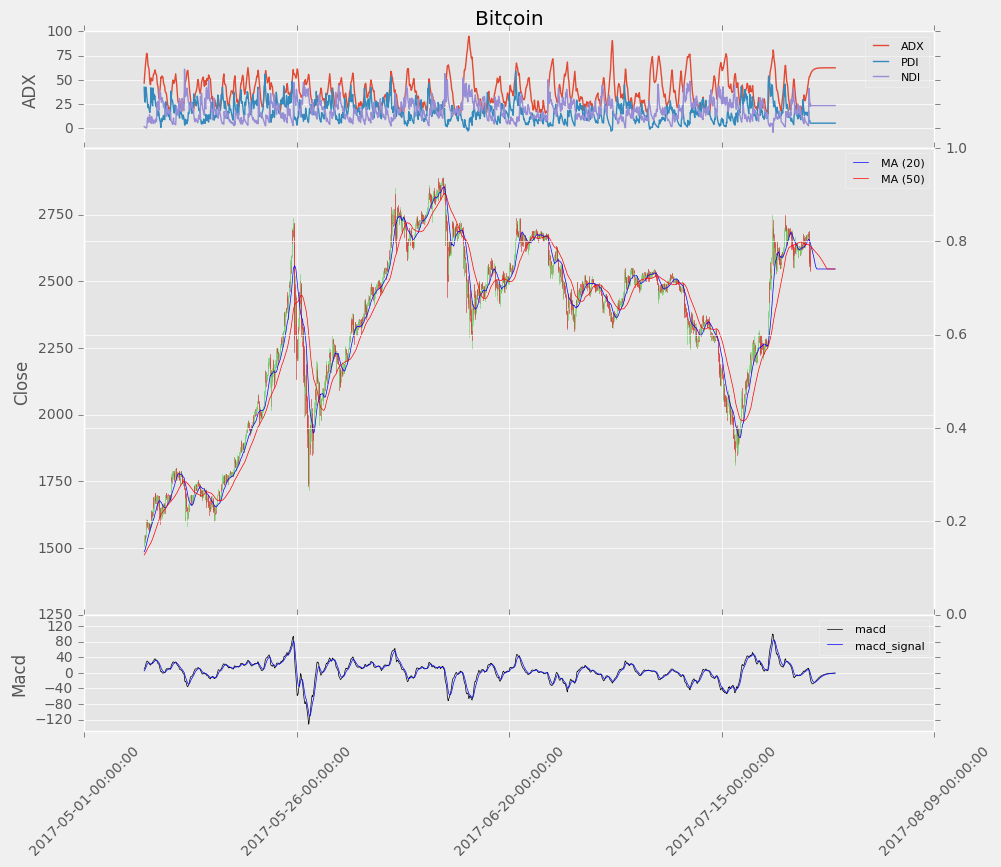

In [65]:
start = len(date[50-1:])
histogram = macd_ti[-start:] - signal_macd[-start:]

fig = plt.figure(figsize = (10,10),facecolor='#f0f0f0')
ax1 = plt.subplot2grid((6,1),(0,0),rowspan=1,colspan=1)
plt.title("Bitcoin")
plt.ylabel("ADX")
ax2 = plt.subplot2grid((6,1),(1,0),rowspan=4,colspan=1,sharex= ax1)
plt.xlabel('Date')
plt.ylabel("Close")
ax2v = ax2.twinx()
ax3 = plt.subplot2grid((6,1),(5,0), rowspan=1, colspan=1,sharex=ax1)
plt.ylabel('Macd')


ax1.plot(date[-start:],adx[-start:],label='ADX')
ax1.plot(date[-start:],pdi[-start:],label='PDI')
ax1.plot(date[-start:],ndi[-start:],label='NDI')
ax1.yaxis.set_major_locator(mticker.MaxNLocator(nbins=5,prune='lower'))

x = 0
y = len(date)
ohlc = []
while x<y:
    append_me = date2num(date[x]),open_[x],high[x],low[x],close[x],volume[x]
    ohlc.append(append_me)
    x+=1

candlestick_ohlc(ax2,ohlc[-start:],width=0.001,colorup='#77d879',colordown='#db3f3f')
ax2.plot(date[-start:], ma20[-start:], color='blue', lw=0.5, label='MA (20)')
ax2.plot(date[-start:], ma50[-start:], color='red', lw=0.5, label='MA (50)')
#start = len(date[ma50]-1:)
ax2.yaxis.set_major_locator(mticker.MaxNLocator(nbins=7,prune='upper'))
ax2.grid(True)

fillcolor = 'darkgoldenrod'

ax3.plot(date[-start:],macd_ti[-start:],color='black', lw=0.5, label= 'macd')
ax3.plot(date[-start:],signal_macd[-start:], color='blue',lw=0.5, label= 'macd_signal')

for label in ax3.xaxis.get_ticklabels():
    label.set_rotation(45)

ax3.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d-%H:%M:%S'))
ax3.xaxis.set_major_locator(mticker.MaxNLocator(4))
ax3.yaxis.set_major_locator(mticker.MaxNLocator(nbins=8,prune='upper'))


ax2.xaxis_date()
ax2.autoscale_view()

plt.setp(ax1.get_xticklabels(), visible=False) # the function plt.setp sets properties for a plotting instance(s) and can change the style of the line to "dashed". 
plt.setp(ax2.get_xticklabels(), visible=False) # This way you can easily change parameters after the plotting instance has been generated
plt.subplots_adjust(left=0.09,bottom=0.20,right=0.94,top=0.90, wspace=0.2,hspace=0)
ax1.legend()
leg = ax1.legend(loc=1, ncol =1,prop= {'size':8})
leg.get_frame().set_alpha(0.4)
ax2.legend()
leg = ax2.legend(loc=1, ncol =1,prop= {'size':8})
leg.get_frame().set_alpha(0.4)
ax3.legend()
leg = ax3.legend(loc=1, ncol =1,prop= {'size':8})
leg.get_frame().set_alpha(0.4)
plt.show()
fig.savefig('bitcoin.png',facecolor=fig.get_facecolor())